# E-Commerce Customer Segmentation

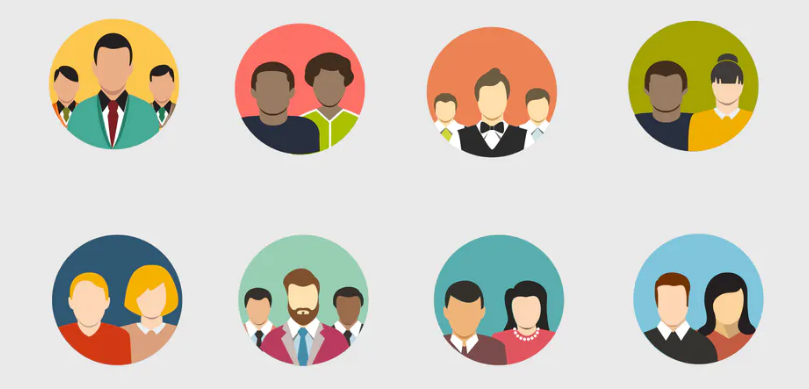

Customer segmentation is an effective tool for businesses to closely align their strategy and tactics with, and better target, their customers. Every customer is different and every customer journey is different so a single approach often isn’t going to work for all. This is where customer segmentation becomes a valuable process.

> Customer segmentation is the process by which you divide your customers into segments up based on common characteristics – such as demographics or behaviors, so you can market to those customers more effectively.

Customer segmentation can be broken down into two types: 
- Segmenting customers based on who they are: the process of understanding who customers are typically focuses on demographics.
- Segmenting customers based on what they do: you can also segment customers based on how much they spend (share of wallet), how often, and what products (this allows you to see how much you can increase spend). This is more behavior focused. **That's the data we have and the kind of segmentation we will do.**


### Research questions
The aim of the study is to answer the below research questions:
- What is the general sales trend?
- What is an average cart by country?
- What countries are the most active?
- What are the best selling products?
- How often do customers buy products?
- How many new customers each months?
- When do customers tend to purchase products?


### About the dataset

Typically e-commerce datasets are proprietary and consequently hard to find among publicly available data. However, The UCI Machine Learning Repository has made this dataset containing actual transactions from 2010 and 2011. The dataset is maintained on their site, where it can be found by the title "Online Retail".

"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

### Features

1. *InvoiceNo*: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
2. *StockCode*: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
3. *Description*: Product (item) name. Nominal. 
4. *Quantity*: The quantities of each product (item) per transaction. Numeric. 
5. *InvoiceDate*: Invice Date and time. Numeric, the day and time when each transaction was generated. 
6. *UnitPrice*: Unit price. Numeric, Product price per unit in sterling. 
7. *CustomerID*: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
8. *Country*: Country name. Nominal, the name of the country where each customer resides.

---

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats
from mpl_toolkits import mplot3d
import datetime as dt

sns.set_style("whitegrid")

Install: seaborn, sklearn, kaleido

---

## 📊 Loading the data

In [2]:
df = pd.read_csv("data/data.csv",encoding = 'unicode_escape')
print("There are {} observations for {} predictors.".format(df.shape[0],df.shape[1]))
df.head()

There are 541909 observations for 8 predictors.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df[(df["InvoiceDate"].dt.year!=2011)|(df["InvoiceDate"].dt.month!=12)]

## 📊 Cleaning the data

### Delete NaN rows

In [5]:
df[df.isin(["NaN","missing","?","??"]).any(axis=1)].shape[0]

56

I will get read of those rows that give no informations on the customers to identify or on the products bought.

In [6]:
df = df[df.isin(["NaN","missing","?","??"]).any(axis=1) == False]

---

### Deal with the description format

There are some inconsistencies in the data descriptions.

In [7]:
df["Description"].nunique()

4211

In [8]:
df["Description"].str.lower().str.strip().nunique()

4183

In [9]:
df["Description"] = df["Description"].str.lower().str.strip()

---
### Dealing with non items

Some descriptions are just fees and not items. We can delete them.

In [10]:
df = df[df["Description"].isin(["amazon fee", "samples", "postage", "packing charge","manual","discount","adjust bad debt","bank charges","cruk commission","next day carriage"]) == False]

---
### Delete null price and quantities

Some items have a quantity or a unit price equals to zero. We can delete those rows.

In [11]:
df = df[(df["UnitPrice"]!=0)&(df["Quantity"]!=0)]

---

### Deal with data inconsistencies
I will check if *the stock code is always linked to one description*.

In [12]:
df["Description"].nunique()

4018

In [13]:
df["StockCode"].nunique()

3924

In [14]:
df.groupby("StockCode")["Description"].nunique().sort_values(ascending = False)

StockCode
23236           4
23196           4
23131           3
23413           3
23370           3
               ..
22419           1
22420           1
22421           1
22422           1
gift_0001_50    1
Name: Description, Length: 3924, dtype: int64

It is the same product, but written in different ways. I will just keep the first description that appears.

In [ ]:
for stack_code in df["StockCode"].unique():
    first_description = df[df["StockCode"]==stack_code]["Description"].unique()[0]
    df.loc[df["StockCode"]==stack_code, "Description"] = first_description

I will check if *the description is always linked to one stock code*.

In [ ]:
df.groupby("Description")["StockCode"].nunique().sort_values(ascending = False)

In [ ]:
for description in df["Description"].unique():
    first_code = df[df["Description"]==description]["StockCode"].unique()[0]
    df.loc[df["Description"]==description, "StockCode"] = first_code

Now we can check again the NaN values:

In [ ]:
df.isnull().sum()

---

### Deal with outliers

In [ ]:
df["TotalPrice"] = df["Quantity"]*df["UnitPrice"]

fig = plt.figure(figsize = (20,5))
fig.suptitle("Visualisation of outliers",size=20)

axes = fig.add_subplot(1, 3, 1)
sns.boxplot(data=df,y="UnitPrice")

axes = fig.add_subplot(1, 3, 2)
sns.boxplot(data=df,y="Quantity")

axes = fig.add_subplot(1, 3, 3)
sns.boxplot(data=df,y="TotalPrice")

In [ ]:
df = df[(np.abs(stats.zscore(df[["TotalPrice"]])) < 3).all(axis=1)]

## 📊 Exploratory Data Analysis


### What is the general sales trend?

To understand the general sales trend, I will plot the amount of money generated by the sales for each day through the studied period.

In [ ]:
general_trend = pd.DataFrame(data={'Date':pd.to_datetime(df.InvoiceDate).dt.date,
                                  'Total price':df.Quantity*df.UnitPrice})
general_trend = general_trend.groupby("Date")["Total price"].sum()
general_trend = pd.DataFrame(general_trend)

In [ ]:
dates = []
dates.append(pd.to_datetime("201012",format="%Y%m"))
dates += [pd.to_datetime("2011"+str(month),format="%Y%m") for month in range(1,12)]

In [ ]:
rolling_days = general_trend.copy()
rolling_days["Total price"] = rolling_days["Total price"].rolling(window=30).mean() 

In [ ]:
plt.figure(figsize = (18,5)).suptitle('Evolution of the General Sales Trend', fontsize=20)
sns.lineplot(data=general_trend)
sns.lineplot(data=rolling_days, palette=['red'])
plt.xticks(dates,rotation = 45)
plt.show()

In [ ]:
general_trend.index = pd.to_datetime(general_trend.index)
general_trend_months = general_trend.groupby([general_trend.index.year,general_trend.index.month])['Total price'].sum()
general_trend_months = pd.DataFrame(general_trend_months)

In [ ]:
general_trend_months

In [ ]:
general_trend_months["Date"] = dates

In [ ]:
plt.figure(figsize = (20,10)).suptitle('General sales for each months', fontsize=25)
lineplot = sns.lineplot(data=general_trend_months,x="Date", y="Total price", marker="o",linewidth = 2)


lineplot.set_xlabel(xlabel="Date",size = 20)
lineplot.set_ylabel(ylabel="Total Price",size = 20)
plt.yticks(fontsize=12)
plt.xticks(dates,rotation = 45,fontsize=12)

plt.show()

> 📌 From this curve giving the sales trend between december 2010 and december 2011, it seems that the general sales was quite stable untill august 2011. The general sales increases drastically and are almost multiplied by 3. This increase may also be linked to end of the year celebrations, where people tend to buy more products.

---

### What is an average cart by country?

In this part I will study the trends per countries to spot any differencies.
First of all try to see if there are difference in the way customers frome each country buy products in term of quantities and prices.

In [ ]:
average_cart_countries = df.groupby("Country").TotalPrice.mean()
average_cart_countries = pd.DataFrame(average_cart_countries).reset_index()

average_price_countries = df.groupby("Country").UnitPrice.mean()
average_price_countries = pd.DataFrame(average_price_countries).reset_index()

average_quantity_countries = df.groupby("Country").Quantity.mean()
average_quantity_countries = pd.DataFrame(average_quantity_countries).reset_index()

In [ ]:
fig = plt.figure(figsize = (20,10))
fig.suptitle("Average quantity, price and total price per country",size=20)

axes = fig.add_subplot(1, 3, 1)
sns.barplot(data=average_cart_countries,x="TotalPrice",y="Country")

axes = fig.add_subplot(1, 3, 2)
sns.barplot(data=average_price_countries,x="UnitPrice",y="Country")
fig.axes[1].get_yaxis().set_visible(False)

axes = fig.add_subplot(1, 3, 3)
sns.barplot(data=average_quantity_countries,x="Quantity",y="Country")
fig.axes[2].get_yaxis().set_visible(False)

In [ ]:
choro_data = dict(
                  type = "choropleth",
                  colorscale = "Agsunset",
                  locations = average_cart_countries["Country"],
                  locationmode = "country names",
                  z = average_cart_countries["TotalPrice"].astype(float).round(0).tolist(),
                  hovertext = average_cart_countries["Country"],
                  hovertemplate = "%{hovertext}: £%{z:,.0f} <extra></extra>",
                  colorbar = {"title" : "Total Price", },
                ) 

layout = dict(
              title = "Average Total Price Per Cart By Country",
              titlefont = dict(size = 20),
              geo = dict(showframe = False, bgcolor = "#BAEAED",),
              margin={"r":0,"t":50,"l":10,"b":0}  
             )

fig = go.Figure(data=choro_data, layout=layout)
#iplot(fig)

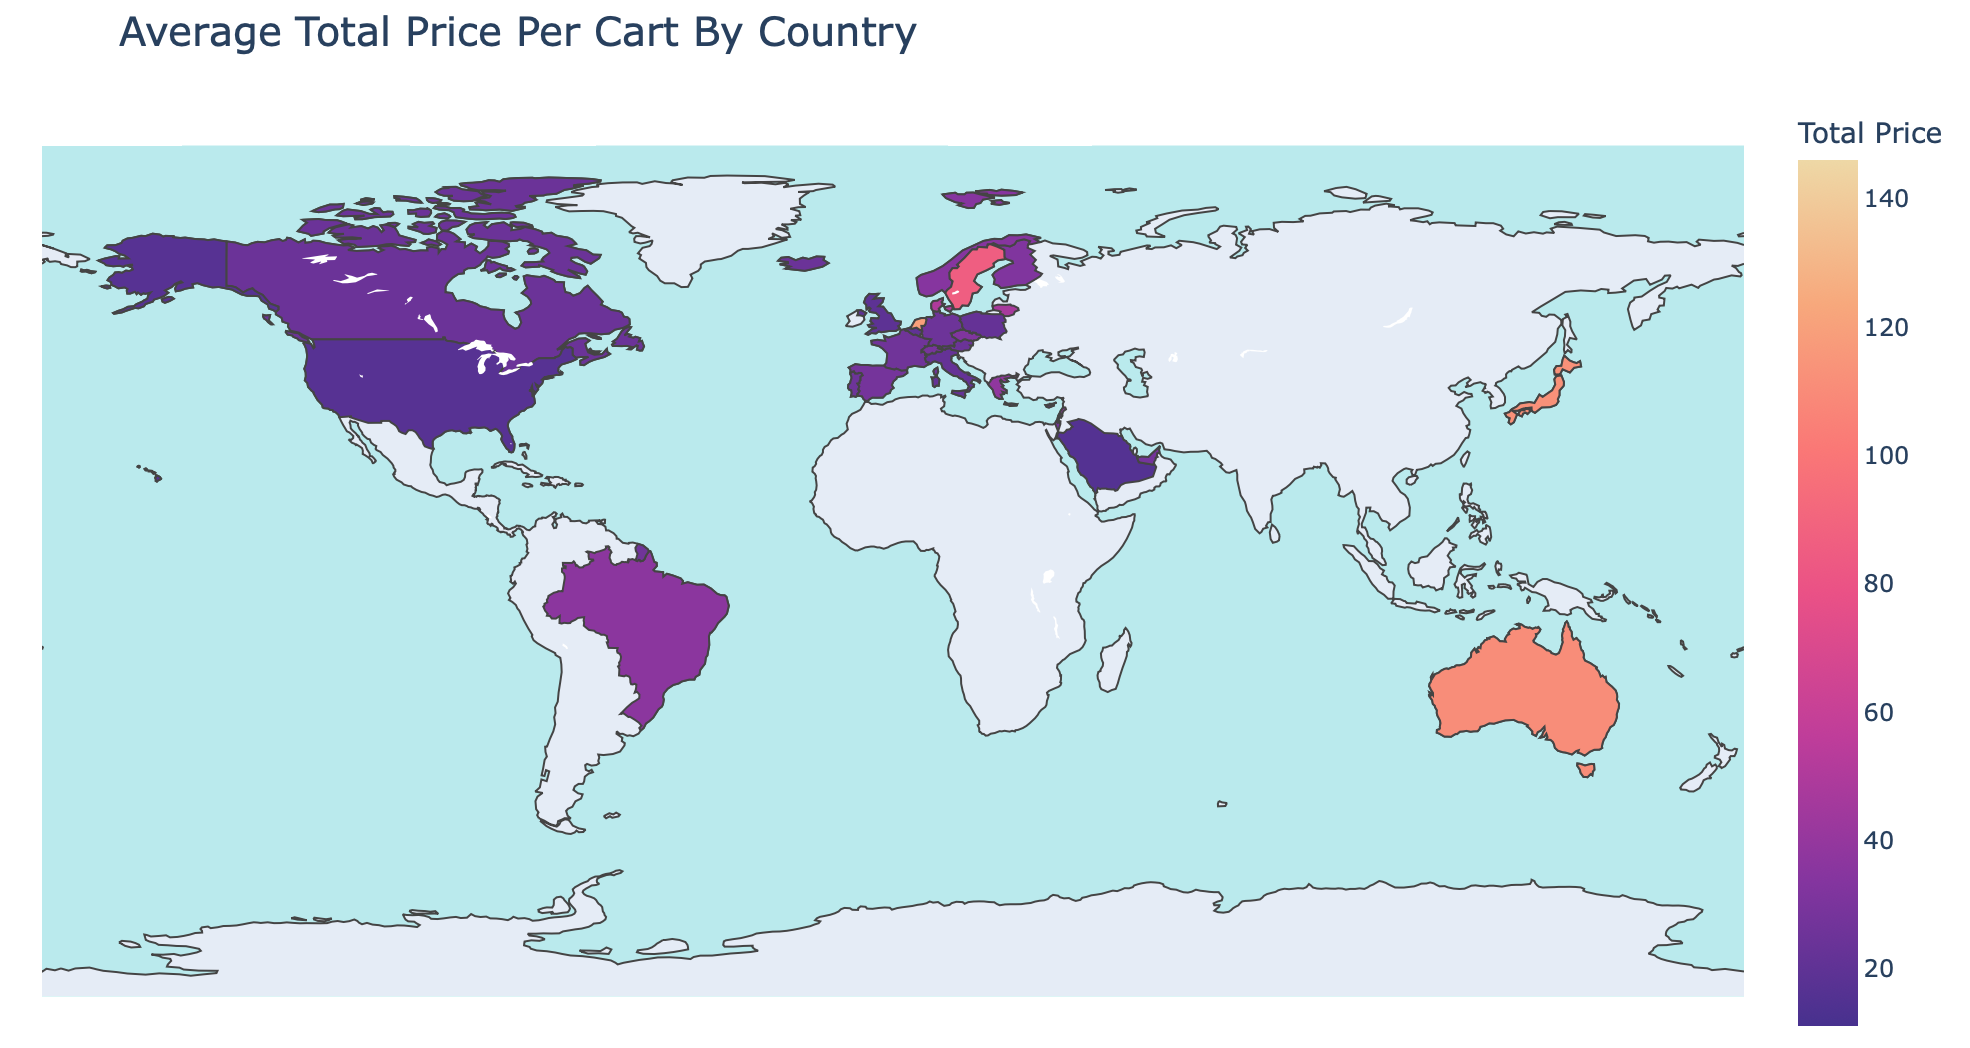

>📌 There are four countries that tend to buy have an average cart bigger than the others: the Netherlands, Australia, Japan and Sweden. Based on the plots for quantity and total prices, it seems that those countries have a bigger carts because of quantities, a customer from those countries will buy more quantities than in others.
>
> Hong Kong and Singapore customers tend to be more attracted by expensive items.

---
### What are the best selling products?

We can also exhibit what items are the best for each countries.

In [ ]:
sum_total_price_products = pd.DataFrame(df.groupby(["Country","Description"])["TotalPrice"].sum())
best_selling_product = pd.DataFrame(data=sum_total_price_products.groupby(["Country"])['TotalPrice'].idxmax().values.tolist(),columns =['Country', 'Best Selling Product'])

max_sales = sum_total_price_products.groupby("Country")["TotalPrice"].max().values.tolist()
best_selling_product["Sales"] = max_sales

total_sales = sum_total_price_products.groupby("Country")["TotalPrice"].sum().values.tolist() 
best_selling_product["Country total sales"] = total_sales

best_selling_product["% of country sales"] = best_selling_product["Sales"]/best_selling_product["Country total sales"]

In [ ]:
best_selling_product \
.style.background_gradient(cmap=sns.light_palette("seagreen", as_cmap=True), \
 subset=["% of country sales"]) \
.format({"% of country sales":"{:.2%}",
         "Sales":"£{:,.0f}",
         "Country total sales":"£{:,.0f}"})

In [ ]:
df.Description.value_counts()[:10]

> 📌 The best selling product is the "white hanging heart T-light holder". The best selling items are different based on the countries.

---

### How often do customers buy products?

In this part, I will study how often customers from the different countries buy items on the website.

In [ ]:
count_transactions_per_country = df.groupby([df.Country,df.InvoiceDate]).Description.count().reset_index()
count_transactions_per_country = count_transactions_per_country.groupby([count_transactions_per_country.Country]).Description.sum()
count_transactions_per_country = pd.DataFrame(count_transactions_per_country)

In [ ]:
unique_per_country = df.groupby([df.Country]).CustomerID.nunique()
unique_per_country = pd.DataFrame(unique_per_country)
unique_per_country = unique_per_country.drop("Hong Kong")

In [ ]:
transactions_per_customer_per_countries = pd.concat([count_transactions_per_country,unique_per_country],axis=1).reset_index()
transactions_per_customer_per_countries["Value"] = transactions_per_customer_per_countries["Description"]/transactions_per_customer_per_countries["CustomerID"]/12

In [ ]:
fig = plt.figure(figsize = (20,15))
fig.suptitle("Average quantity, price and total price per country",size=50)

axes = fig.add_subplot(1, 2, 1)
sns.barplot(data=transactions_per_customer_per_countries,x="Value",y="Country")
axes.set_xlabel('Transactions per month in average per customer',size = 30)
axes.set_ylabel('Country',size = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

axes = fig.add_subplot(1, 2, 2)
sns.barplot(data=transactions_per_customer_per_countries,x="CustomerID",y="Country")
axes.set_xlabel('Number of different customers',size = 30)
axes.set_ylabel('')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.subplots_adjust(right=1.5)

plt.show()

In [ ]:
transactions_per_customer_without_ireland = transactions_per_customer_per_countries[transactions_per_customer_per_countries.Country!="EIRE"]
choro_data = dict(
                  type = "choropleth",
                  colorscale = "Agsunset",
                  locations = transactions_per_customer_without_ireland["Country"],
                  locationmode = "country names",
                  z = transactions_per_customer_without_ireland["Value"].astype(float).round(0).tolist(),
                  hovertext = transactions_per_customer_without_ireland["Country"],
                  hovertemplate = "%{hovertext}: £%{z:,.0f} <extra></extra>",
                  colorbar = {"title" : "Transactions", },
                ) 



layout = dict(
              title = "Transactions Per Month In Average Per Customer Excluding Ireland",
              titlefont = dict(size = 20),
              geo = dict(showframe = False, bgcolor = "#BAEAED",),
              margin={"r":0,"t":50,"l":10,"b":0}  
             )

fig = go.Figure(data=choro_data, layout=layout)
#iplot(fig)

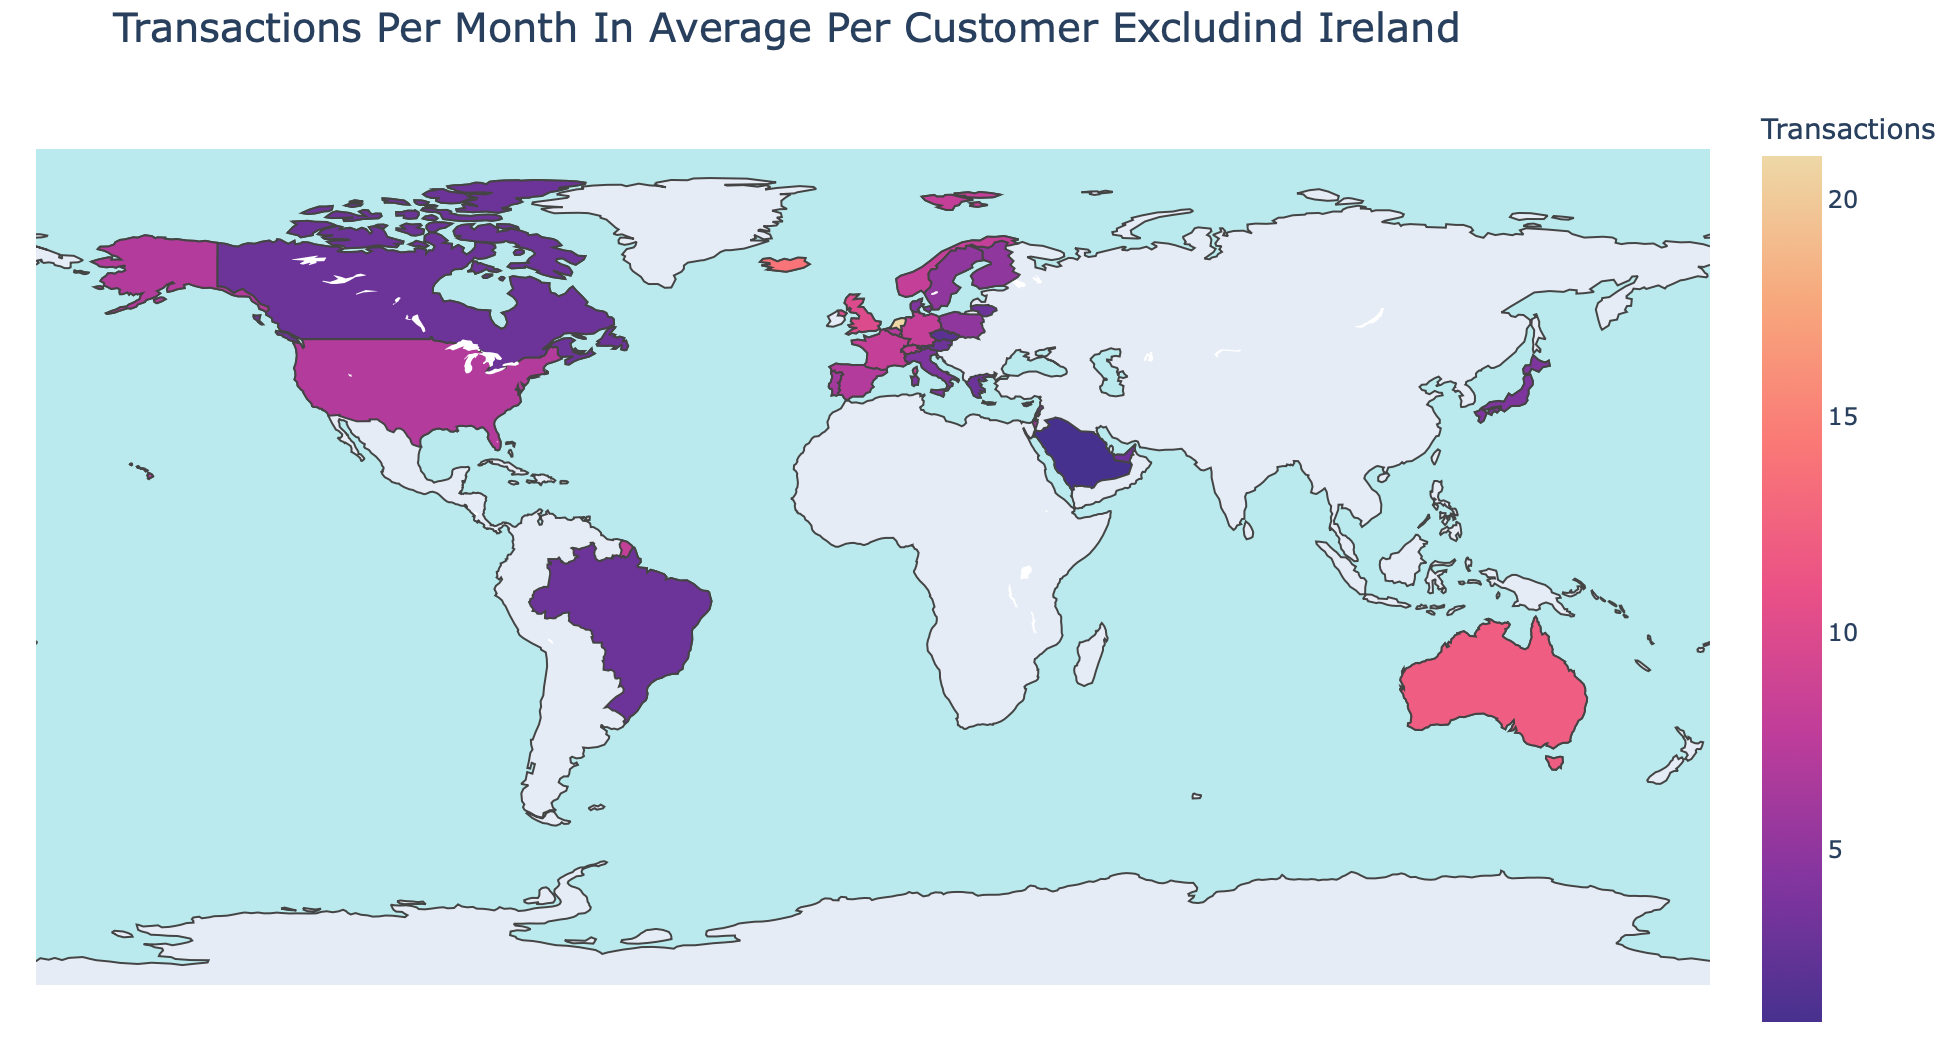

We can calculate the global average for the number of transaction per month per customers:

In [ ]:
transactions_per_customer_per_countries.Description.sum()/transactions_per_customer_per_countries.CustomerID.sum()/12

> 📌 This graph highlights that in average, customers will customers will make around 10 transactions per month. There is one big exception with Ireland, where there is an average of 225 transaction but this is linked to only three customers.
>
> It is also visible that most of the customers comes from UK with almost 4,000 unique customers, then France and Germany far behind with around 100.

---

### What countries are the most active?

In [ ]:
general_trend_country = pd.DataFrame(data={'Date':pd.to_datetime(df.InvoiceDate),
                                   'Country':df.Country,
                                  'Total price':df.Quantity*df.UnitPrice})
general_trend_country = general_trend_country.groupby([general_trend_country.Date.dt.to_period("M"),general_trend_country.Country]).sum()
general_trend_country = pd.DataFrame(general_trend_country).reset_index()


In [ ]:
general_trend_country.groupby([general_trend_country.Country]).sum().sort_values(by='Total price',ascending=False).head(10)

In [ ]:
general_trend_country.Date = general_trend_country.Date.dt.to_timestamp()

In [ ]:
plt.figure(figsize = (20,10)).suptitle('General sales for each months per country', fontsize=25)
lineplot = sns.lineplot(data=general_trend_country.loc[general_trend_country.Country!="United Kingdom"],x="Date", y="Total price",hue="Country", marker="o",linewidth = 2)

x_dates = pd.to_datetime(dates).strftime('%Y-%m').sort_values().unique()

lineplot.set_xlabel("Date",fontsize=20)
lineplot.set_ylabel("Total Sales",fontsize=20)
plt.yticks(fontsize=12)
plt.xticks(x_dates,rotation = 45,fontsize=12)
plt.legend(loc='upper left')

plt.show()

In [ ]:
country_sales = pd.DataFrame(general_trend_country[general_trend_country.Country!="United Kingdom"].groupby("Country")["Total price"].sum()).reset_index()

In [ ]:
choro_data = dict(
                  type = "choropleth",
                  colorscale = "Agsunset",
                  locations = country_sales["Country"],
                  locationmode = "country names",
                  z = country_sales["Total price"].astype(float).round(0).tolist(),
                  hovertext = country_sales["Country"],
                  hovertemplate = "%{hovertext}: £%{z:,.0f} <extra></extra>",
                  colorbar = {"title" : "Total Price", },
                ) 



layout = dict(
              title = "Total Sales For Each Countries Excludind UK",
              titlefont = dict(size = 20),
              geo = dict(showframe = False, bgcolor = "#BAEAED",),
              margin={"r":0,"t":50,"l":10,"b":0}  
             )

fig = go.Figure(data=choro_data, layout=layout)
#iplot(fig)

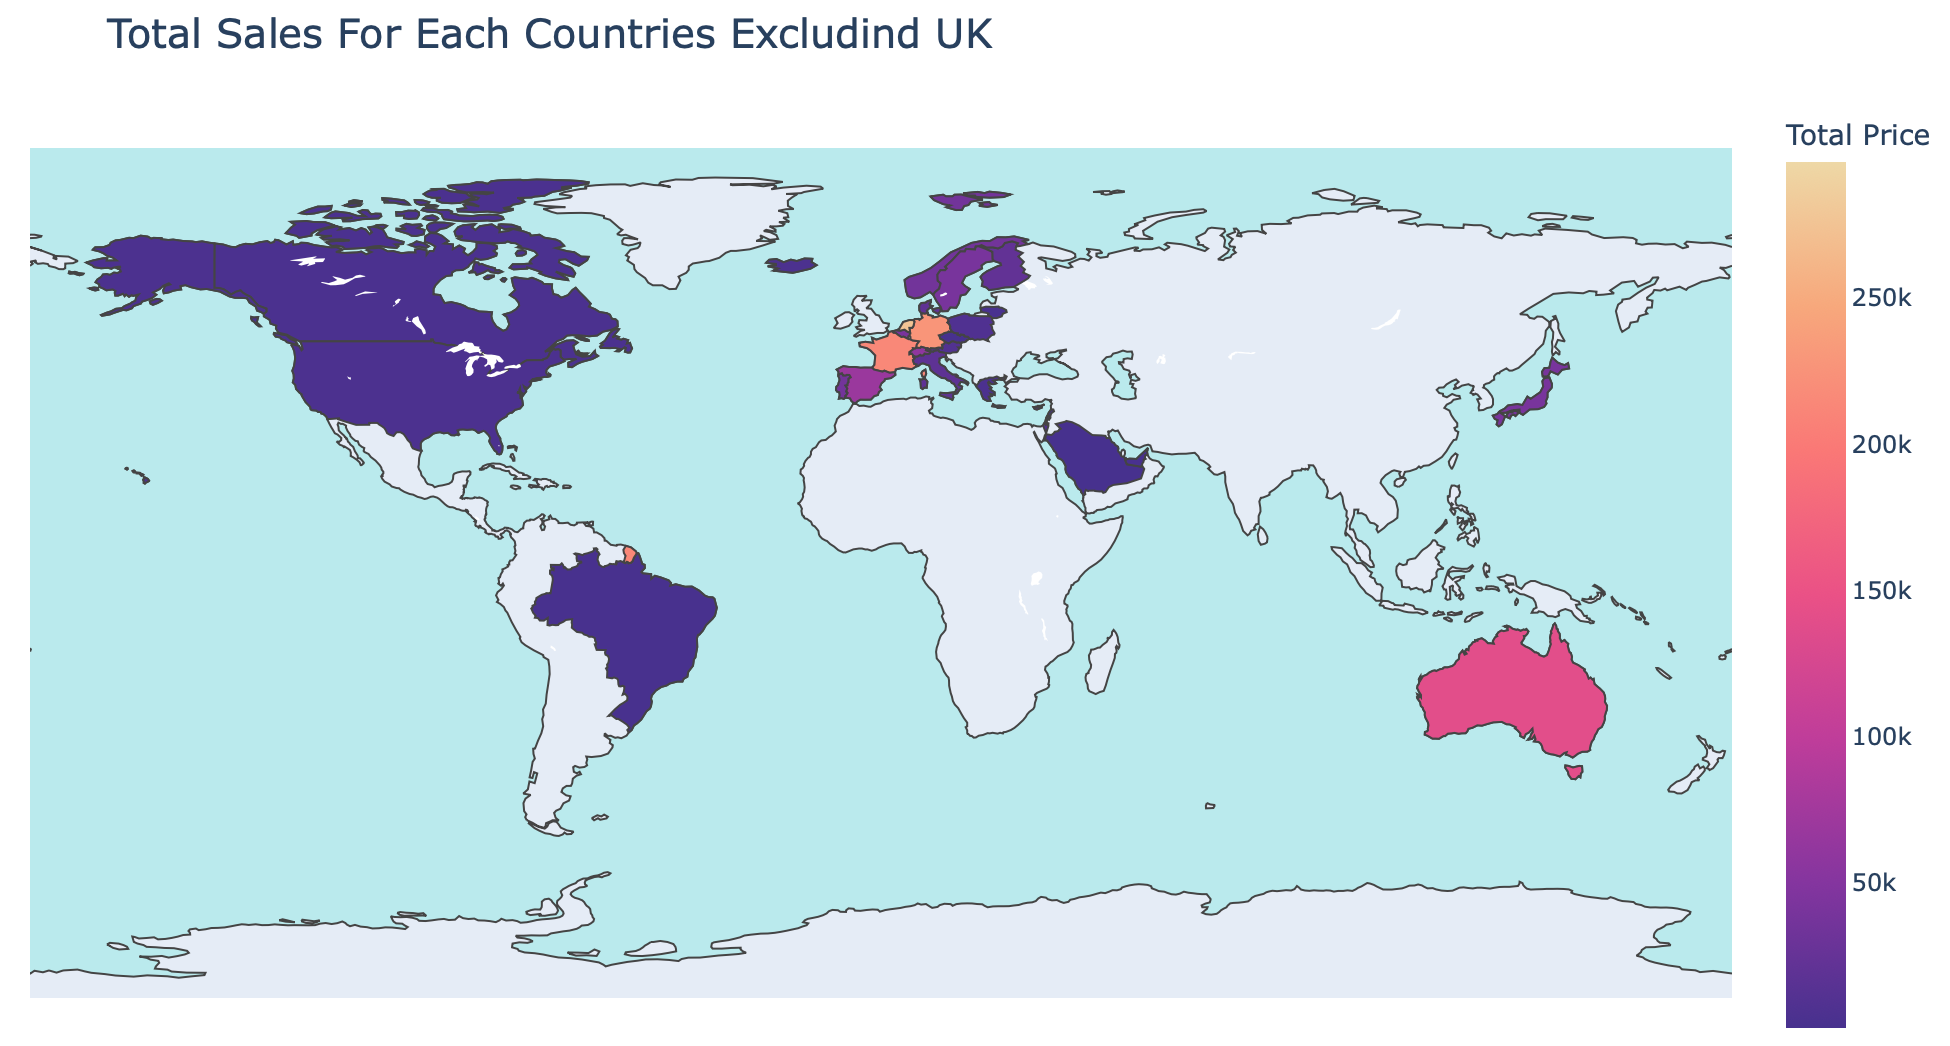

> 📌 Obviously, since the E-Commerce website is from UK, as expected the biggest market is there. Other countries seem to be quite interesting markets too especially in Europe such as the Netherlands, Ireland, Germany France and also Australia.
> Thus it may be interesting to try to develop those countries since for the moment the main customers origin is UK.
>
> However since most of the sales comes from United Kingdom, th increse of august 2011 is mainly due to UK market.

---

### How many new customers each months?

In [ ]:
number_customers = df.groupby(df["InvoiceDate"].dt.to_period('M'))["CustomerID"].nunique()
number_customers = pd.DataFrame(data=number_customers).reset_index()
number_customers["Date"] = number_customers.InvoiceDate.dt.to_timestamp()

number_new_customers = []
customers_seen = []
for month in df["InvoiceDate"].dt.to_period('M').unique():
    customers = df[df["InvoiceDate"].dt.to_period('M') == month].CustomerID.unique()
    count=0
    for customer in customers:
        if customer not in customers_seen:
            count+=1
            customers_seen.append(customer)
    number_new_customers.append((month,count))
number_new_customers = pd.DataFrame(number_new_customers,columns=["Date","New customers"])
number_new_customers.Date = number_new_customers.Date.dt.to_timestamp()

In [ ]:
fig  = plt.figure(figsize = (20,10)).suptitle('Customers Per Month', fontsize=30)
lineplot = sns.lineplot(data=number_new_customers,x="Date", y="New customers", marker="o",linewidth = 2, label="New customers")
sns.lineplot(data=number_customers,x="Date", y="CustomerID", marker="o",linewidth = 2, label="Distinct customers")

lineplot.set_xlabel("Date",fontsize=20)
lineplot.set_ylabel("Customers",fontsize=20)
plt.xticks(dates,rotation = 45,fontsize=12)
plt.yticks(fontsize=12)
plt.show()

> 📌 The number of new customers keeps decreasing probably due to the fact that we don't have enough historical data and some customers were already here before.
>
> However there is a real increase in customer acquisition on august 2011 probably due to a marketing campain targeting prospects. This probably explains the rise in the general sales trend studied above.
> But we can see that in august the customers curve increase more than the number of new customers: so previous customers have probably been also stimulated.

---

### When do customers tend to purchase products?

In this part, I will try to understand if customers tend to purchase items in more particular time of the day.

In [ ]:
df_temp = df.groupby([df.CustomerID,df.InvoiceDate]).Quantity.sum()
df_temp = pd.DataFrame(df_temp).reset_index()

In [ ]:
df_temp["Hour"]= df_temp["InvoiceDate"].dt.hour
df_temp["Month"]= df_temp["InvoiceDate"].dt.to_period('M')

In [ ]:
count_hours = pd.DataFrame(columns=range(1,25))
count_hours["Month"] = ""

for month in sorted(df_temp["Month"].unique()):
    row = []
    for hour in range(1,25):
        freq = len(df_temp[(df_temp["Month"]==month)&(df_temp["Hour"]==hour)])
        row.append(freq)
    row.append(month)
    count_hours.loc[len(count_hours)] = row
    
count_hours = count_hours.fillna(0)       
count_hours = count_hours.set_index("Month")    

In [ ]:
fig  = plt.figure(figsize = (20,10)).suptitle('Number of Transactions Per Hours', fontsize=30)
heatmap = sns.heatmap(data=count_hours)
plt.yticks(rotation=0,size=15)
plt.xticks(size=15)
heatmap.set_xlabel("Hour",fontsize=20)
heatmap.set_ylabel("Month",fontsize=20)
for i in range(count_hours.shape[1] + 1):
    plt.axhline(i, color='white', lw=10
               )

plt.show()

To describe the parts of the day, I used as a reference the [Britannica Dictionary](https://www.britannica.com/dictionary/eb/qa/parts-of-the-day-early-morning-late-morning-etc).

In [ ]:
def daytime_encoder(date):
    if (date.hour >= 5)&(date.hour < 8):
        return "Early morning"
    elif (date.hour >= 8)&(date.hour < 11):
        return "Morning"
    elif (date.hour >= 11)&(date.hour < 13):
        return "Late morning"
    elif (date.hour >= 13)&(date.hour < 14):
        return "Early afternoon"
    elif (date.hour >= 14)&(date.hour < 15):
        return "Afternoon"
    elif (date.hour >= 15)&(date.hour < 17):
        return "Late afternoon"
    elif (date.hour >= 17)&(date.hour < 21):
        return "Evening"
    else:
        return date.hour

df_temp['InvoiceDate'] = df_temp['InvoiceDate'].map(daytime_encoder)

In [ ]:
fig  = plt.figure(figsize = (15,7)).suptitle('Number of transactions per daytime', fontsize=25)
countplot = sns.countplot(data=df_temp,x="InvoiceDate",order = ["Night","Early morning","Morning","Late morning","Early afternoon","Afternoon","Late afternoon","Evening"], palette="Set3")

countplot.set_xlabel("Daytime",fontsize=20)
countplot.set_ylabel("Count",fontsize=20)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

>  📌 It seems that most of the transaction are made during late morning between 11am and 12am. 
> On early morning though between 5am and 8am, there are not a lot of transactions made. And at night there are litterally no transactions at all.

---

## 📊 RFM - Segmentation of the customers

RFM analysis is a **marketing technique** used to quantitatively **rank and group customers** based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns. The system assigns each customer numerical scores based on these factors to provide an objective analysis. RFM analysis is based on the marketing adage that "80% of your business comes from 20% of your customers."

RFM analysis ranks each customer on the following factors:

- **Recency**. *How recent* was the customer's last purchase? Customers who recently made a purchase will still have the product on their mind and are more likely to purchase or use the product again. Businesses often measure recency in days. But, depending on the product, they may measure it in years, weeks or even hours.

- **Frequency**. *How often* did this customer make a purchase in a given period? Customers who purchased once are often are more likely to purchase again. Additionally, first time customers may be good targets for follow-up advertising to convert them into more frequent customers.

- **Monetary**. *How much money* did the customer spend in a given period? Customers who spend a lot of money are more likely to spend money in the future and have a high value to a business.

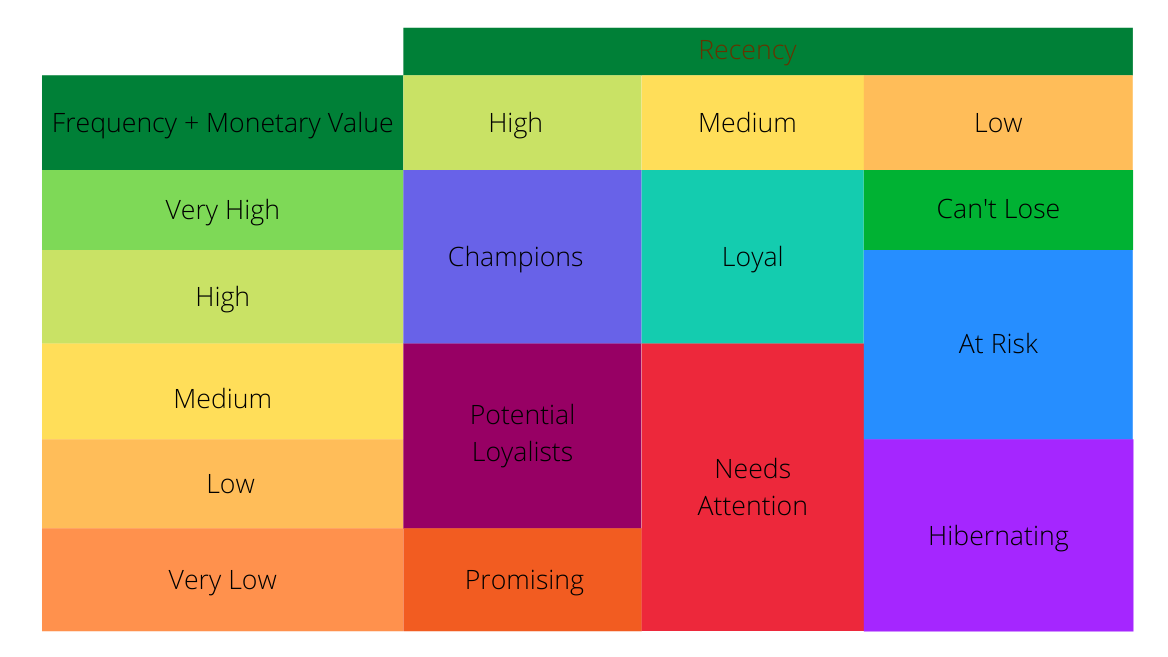

In [ ]:
today_date = dt.datetime(2011, 12, 1)

In [ ]:
rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                     'InvoiceNo'    : lambda InvoiceNo: InvoiceNo.nunique(),
                                     'TotalPrice' : lambda TotalPrice: TotalPrice.sum()})

rfm.columns = ['recency', 'frequency', 'monetary']

In [ ]:
#more days since last purchase 1 (very bad) ; those with fewer days 5 (very good).
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

#5 (very good) for those with high purchasing frequency; the ones that were less as 1 (very bad).
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

#5 (very good) for those with a high purchase price;  the fewer purchase price as 1 (very bad).
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

#we'll not include monetory_score.
rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))

In [ ]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.reset_index(inplace=True)
rfm.head()

In [ ]:
segments_count = rfm.groupby("segment").agg({"CustomerID": "count"})
segments_count.reset_index(inplace=True)
segments_count.columns = ['segment', 'count']
segments_count.head(15)

In [ ]:
fig  = plt.figure(figsize = (20,10)).suptitle('Custumers Distribution of Segments', fontsize=25)
plt.pie(segments_count["count"], labels = segments_count["segment"], autopct='%.0f%%')

plt.show()

In [ ]:
agg_list=["mean", "count", "max"]
rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(agg_list)

> 📌 Apparently there are 15% of customers considered as Champions.
> These customers are responsible for a big share of your revenue so we can put a lot of effort into keeping imroving their experience. What we can do:
> - Give them something extra that the regulars do not get, for example, **limited series of products** or special **discounts** to make them feel valued. 
> - Use communication similar to the "Loyal" segment. For example **making them ambassadors**, giving them a margin of your profits for bringing you, new customers.
> - Ask them for **feedbacks** as they might know the products and services very well.

--- 

## 📊 Clustering - Segmentation of the customers

In [ ]:
df_clustering = df.groupby('CustomerID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                     'InvoiceNo'    : 'nunique',
                                     'TotalPrice' : 'sum'})

df_clustering.columns = ['recency', 'frequency', 'monetary']

In [ ]:
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df_clustering)
df_scaled = pd.DataFrame(df_scaled,columns=['recency', 'frequency', 'monetary'])
df_scaled["CustomerID"] = df_clustering.index
df_scaled = df_scaled.set_index("CustomerID",drop=True)

To determine the optimal number of clusters, I will use the elbow method.

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,11), timings= False)
visualizer.fit(df_scaled)        
visualizer.show()        

In [ ]:
kmeans = KMeans(n_clusters=4, n_init = 15, random_state=1)
kmeans.fit(df_scaled)
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(df_scaled) )
centroid_df

In [ ]:
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))
df_labels['labels'] = df_labels['labels'].astype('category')

In [ ]:
df_kmeans = df_clustering.copy()
df_kmeans['labels'] = df_labels['labels'].values

In [ ]:
fig  = plt.figure(figsize = (15,15)).suptitle('Plot of Customer\'s Distribution', fontsize=25)
ax = plt.axes(projection='3d')
ax.plot3D(xs=df_kmeans["recency"], ys=df_kmeans["frequency"], zs=df_kmeans["monetary"], marker='o', linestyle='None')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()

In [ ]:
agg_list=["mean", "count", "max",]
df_kmeans[["labels", "recency", "frequency", "monetary"]].groupby("labels").agg(agg_list)

In [ ]:
df_kmeans = df_kmeans.reset_index()
clusters_count = df_kmeans.groupby("labels").agg({"CustomerID": "count"})
clusters_count.reset_index(inplace=True)
clusters_count.columns = ['cluster', 'count']

fig  = plt.figure(figsize = (20,10)).suptitle('Customers Distribution of Clusters', fontsize=25)
plt.pie(clusters_count["count"], labels = clusters_count["cluster"], autopct='%.0f%%')

plt.show()

> 📌 From the KMeans clustering, we can sort every customer into 4 different clusters that seems to have different behaviours.
> - **Cluster 0**: "Punctual customers" - Those are the customers that buys more punctually items on the website.
> - **Cluster 1**: "Hibernating customers" - Those are the customers that buys at the lowest frequency, the lowest recently and that spend the least money.
> - **Cluster 2**: "Exceptional customers" - Those are the customers that we want to keep, that buys at the highest frequency, the most recently and that spend the most money. 
> - **Cluster 3**: " Recent customers" - Those are customers that have been active quite recently that might be interesting to keep stimulated.
> 
> The total distorsion score obtained is 4129 using the recency, the frequency and the monetary.

---

## Take away points

> **1.**  The general sales trend seems to increase on august 2011, mainly due to the UK market. We can see a clear increase in the number of new customers during this month. However, some other countries such as France, Germany, Spain, Autralia and the Netherlands are quite active too.
>
> **2.**  Some countries tend to have bigger average carts than other: Australia, Japan, Sweden and the Netherlands.
>
> **3.** There are differencies in the best-selling items based on the country. The best-selling item overall is the white hanging heart t-light holder.
>
> **4.** In average, a customer will come around 10 times on the website to buy items. But Ireland seem to have pretty active customers.
>
> **5.** Apparently the most active moment of the day is around noon, most of the customers purchase items during thios time of the day.
>
> **6. Segmentation**: 
> - *RFM*: Separated all the customers into 10 informative categories based on their recency, frequency and monetary. 
> - *KMeans*: Separated the customers into 4 groups that have similarities based on their recency, frequency and monetary. This time the categories are more flexible and not based on a grade.
>
> **7.** From the two segmentations we learnt that there are *a few exceptional customers* that we would want to keep offering them *discounts*, or an *ambassador title*. There is also a quarter of the customers that are *not really active* and don't spend a lot. 